In [1]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install imgaug

In [3]:
from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError

/tmp/ipykernel_34/2927579722.py:1: DeprecationWarning: Please import `QhullError` from the `scipy.spatial` namespace; the `scipy.spatial.qhull` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.spatial.qhull import QhullError


In [4]:
import os
import cv2
import imgaug.augmenters as iaa
from tqdm import tqdm

def augment_images(input_folder, output_folder, num_copies=4):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Define augmentation pipeline
    seq = iaa.Sequential([
        iaa.Affine(rotate=(-90, 90)),        # 90-degree rotation
        iaa.Fliplr(1.0),                     # Flip left-right
        iaa.ShearX(shear=(-15, 15)),           # Shear rotation up to 10%
        iaa.Crop(percent=(0, 0.1)),           # Crop up to 10%
        iaa.Affine(rotate=(-180, 180)),
       #iaa.Affine(rotate=(-360, 360)),
        #iaa.Affine(scale=(0.8, 1.5)),
        #iaa.GaussianBlur(sigma=(0.0, 1.0)),
        #iaa.Multiply((0.8, 1.5), per_channel=0.2),
        #iaa.MultiplyHue((0.9, 1.6)),
    ])

    # Loop through each image in the input folder
    for filename in tqdm(os.listdir(input_folder)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_folder, filename)

            # Read the image
            image = cv2.imread(image_path)

            # Apply augmentation and save augmented copies
            for i in range(num_copies):
                augmented_image = seq.augment_image(image)
                output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_aug_{i}.png")
                cv2.imwrite(output_path, augmented_image)

if __name__ == "__main__":
    # Specify input and output folders
    input_folder_blacksigatoka = r"/kaggle/input/ann-siftdiseasewisedataset/BlackSigatoka"
    input_folder_furasiumwilt = r"/kaggle/input/ann-siftdiseasewisedataset/FurasiumWilt"
    input_folder_cordana=r"/kaggle/input/ann-siftdiseasewisedataset/Cordana"
    output_folder_cordana=r"/kaggle/working/BLD_augmented_data2/Cordana"
    output_folder_blacksigatoka = r"/kaggle/working/BLD_augmented_data2/BlackSigatoka"
    output_folder_furasiumwilt = r"/kaggle/working/BLD_augmented_data2/FurasiumWilt"

    # Specify the number of copies per image
    #num_copies = 2

    # Perform augmentations
    augment_images(input_folder_blacksigatoka, output_folder_blacksigatoka, 2)
    augment_images(input_folder_furasiumwilt, output_folder_furasiumwilt, 2)
    augment_images(input_folder_cordana, output_folder_cordana, 8)


100%|██████████| 162/162 [00:11<00:00, 14.19it/s]


In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Succesfully imported packeges")

Succesfully imported packeges


In [6]:
import cv2
import numpy as np
import os

# Function to extract SIFT features and descriptors from an image based on color range
def extract_sift_features(image_path, max_features=1000, color_range=None):
    # Read the image
    img = cv2.imread(image_path)
    
    # Check if the image is loaded successfully
    if img is None:
        print(f"Error: Unable to load image from '{image_path}'")
        return None
    
    # Convert BGR to HSV
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Threshold the HSV image to get only specific colors
    if color_range is not None:
        lower_color = np.array(color_range[0])
        upper_color = np.array(color_range[1])
        mask = cv2.inRange(hsv_img, lower_color, upper_color)
        # Bitwise-AND mask and original image
        masked_img = cv2.bitwise_and(img, img, mask=mask)
        # Convert the masked image to grayscale
        gray_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2GRAY)
    else:
        # Convert the image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Create SIFT object
    sift = cv2.SIFT_create(nfeatures=0, nOctaveLayers=3, contrastThreshold=0.03, edgeThreshold=10, sigma=1.6)
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray_img, None)
    
    # If descriptors are found
    if descriptors is not None:
        # Use only the first 'max_features' descriptors to ensure fixed length
        descriptors = descriptors[:max_features, :]
        
        # Draw keypoints on the original image
        img_with_keypoints = cv2.drawKeypoints(img, keypoints, None)
        
        # Show the original image with keypoints
#         cv2.imshow('Image with Keypoints', img_with_keypoints)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        
        return descriptors.flatten()  # Flatten descriptors for printing
    else:
        # If no descriptors are found, return zeros
        return np.zeros(max_features * 128)




In [7]:
def load_data(folder_path):
    X = []
    y = []
    label_mapping = {'Cordana': 0, 'FurasiumWilt': 1}
    max_features = 100  # Adjust this value based on your dataset and available memory
    count = 0
    for label in label_mapping.keys():
        label_folder = os.path.join(folder_path, label)
        for filename in os.listdir(label_folder):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                count += 1
                image_path = os.path.join(label_folder, filename)
                # Extract features based on color range for the label
                color_range = None
                if label == 'FurasiumWilt':
                    color_range = ([20, 100, 100], [30, 255, 255])  # Yellow and black
                elif label == 'Cordana':
                    color_range = ([10, 50, 50], [30, 255, 255])  # Brown
                features = extract_sift_features(image_path, max_features, color_range)
                X.append(features)
                y.append(label_mapping[label])

    return X, y

In [9]:
dataset_path = r"/kaggle/working/BLD_augmented_data2"

In [10]:
X, y = load_data(dataset_path)

In [11]:
max_length = max(len(x) for x in X)
X_padded = [np.pad(x, (0, max_length - len(x))) for x in X]
features = np.array(X_padded)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Split the data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
len(X_test)

476

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
# X_test_scaled = scaler.transform(X_test)

In [15]:
# Convert y_train, y_val, and y to NumPy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)
y = np.array(y)

In [16]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from itertools import product

2024-03-07 08:07:42.139384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 08:07:42.139500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 08:07:42.309009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [17]:
# # model = Sequential()
# # model.add(Dense(128, input_dim=12800, activation='relu'))
# # model.add(Dense(64, activation='relu'))
# # model.add(Dense(units=1, activation='sigmoid'))
# # model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# from keras.models import Sequential
# from keras.layers import Dense, Dropout

# model = Sequential()
# model.add(Dense(256, input_dim=12800, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))  # Adding dropout for regularization
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))  # Adding dropout for regularization
# model.add(Dense(32, activation='relu'))
# model.add(Dense(units=1, activation='sigmoid'))

# model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])


I0000 00:00:1709798879.694012     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


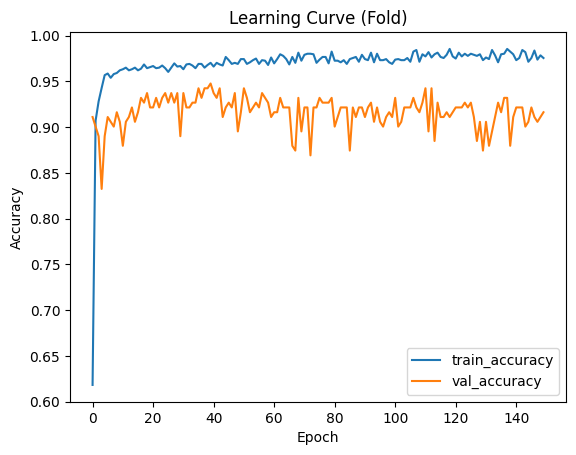

0.9162303805351257


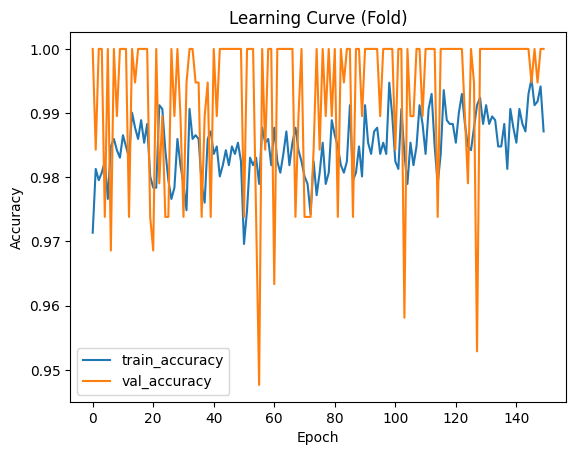

1.0


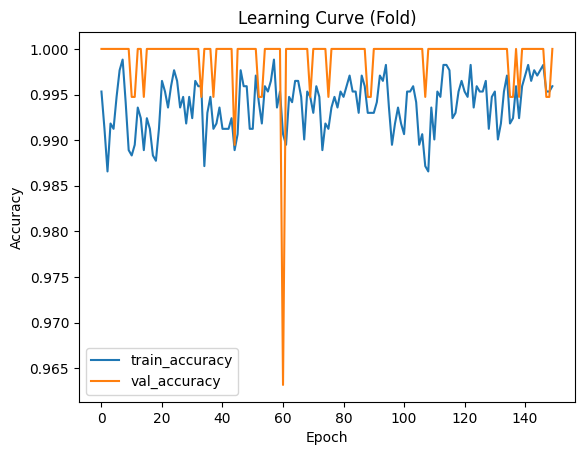

1.0


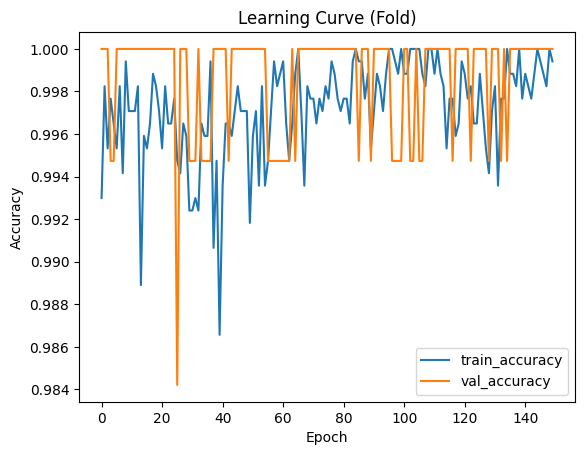

1.0


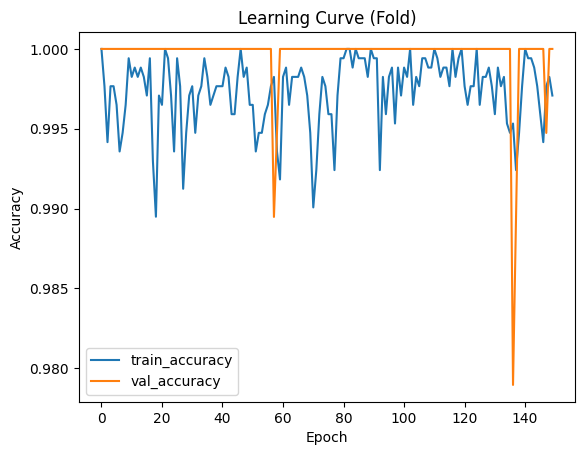

1.0


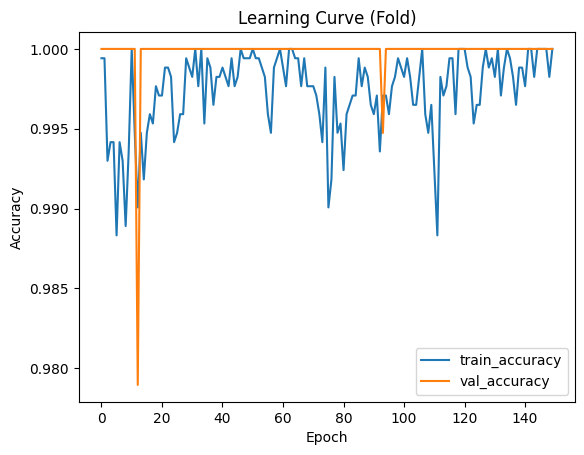

1.0


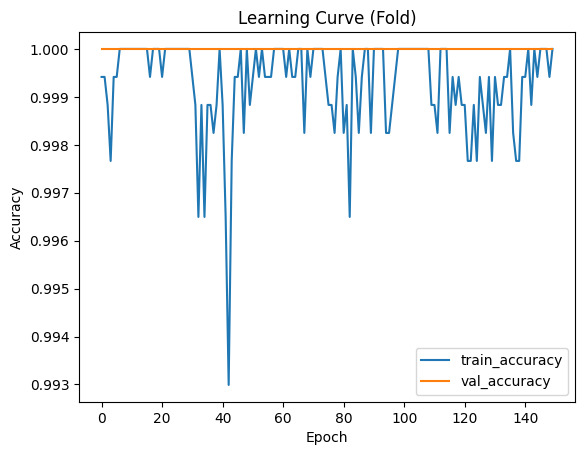

1.0


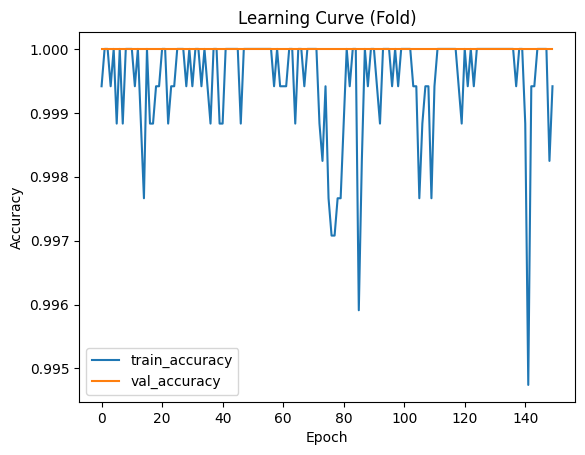

1.0


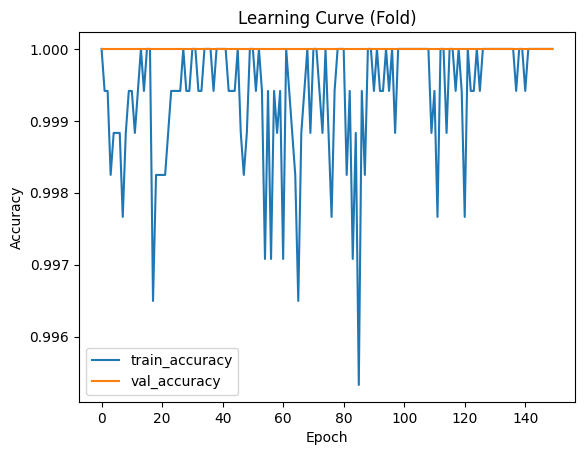

1.0


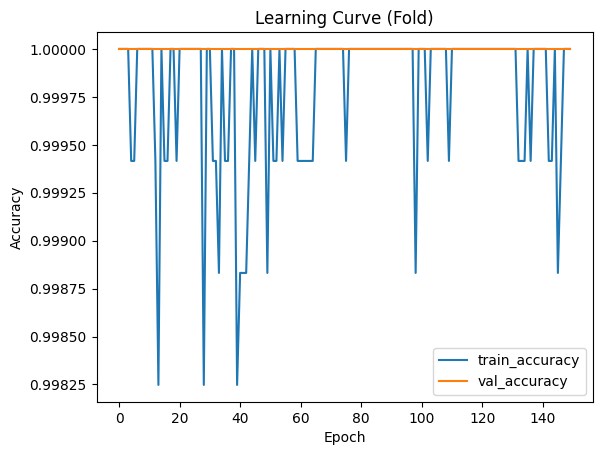

1.0
Mean Accuracy during Cross-Validation: 0.9916230380535126
15/15 [==============================] - 0s 5ms/step - loss: 1.3970 - accuracy: 0.9181
Test Accuracy on Separate Test Set: 0.918067216873169
15/15 [==============================] - 0s 4ms/step

Final Model Accuracy: 91.81%
Confusion Matrix:
[[246  13]
 [ 26 191]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       259
           1       0.94      0.88      0.91       217

    accuracy                           0.92       476
   macro avg       0.92      0.91      0.92       476
weighted avg       0.92      0.92      0.92       476



In [18]:
from itertools import product
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt

# Define the hyperparameter combinations to try
optimizers = ['adam', 'sgd']
loss_functions = ['binary_crossentropy', 'mean_squared_error']
activation_functions = ['relu', 'sigmoid']
metrics = ['accuracy']

best_accuracy = 0
best_params = {'optimizer': 'adam', 'loss': 'binary_crossentropy', 'activation': 'sigmoid', 'metric': 'accuracy'}

# Build the final model with the best hyperparameters
final_model = Sequential()
final_model.add(Dense(12800, input_dim=12800, activation=best_params['activation']))
final_model.add(Dropout(0.3))  # Adding dropout for regularization
final_model.add(Dense(1024, activation=best_params['activation']))
final_model.add(Dropout(0.3))  # Adding dropout for regularization
final_model.add(Dense(512, activation=best_params['activation']))
final_model.add(Dropout(0.3))  # Adding dropout for regularization
final_model.add(Dense(256, activation=best_params['activation']))
final_model.add(Dropout(0.3))  # Adding dropout for regularization
final_model.add(Dense(64, activation=best_params['activation']))
final_model.add(Dropout(0.3))  # Adding dropout for regularization
final_model.add(Dense(64, activation=best_params['activation']))
final_model.add(Dropout(0.3))
final_model.add(Dense(1, activation='sigmoid'))  # Adjusted for binary classification

# Compile the final model
final_model.compile(loss=best_params['loss'], optimizer=best_params['optimizer'], metrics=[best_params['metric']])

# Step 4: Use StratifiedKFold for stratified cross-validation in classification problems
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores = []

# Step 5: Iterate over folds for cross-validation
for train_index, val_index in cv.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Create and train the model
    history = final_model.fit(X_train_fold, y_train_fold, epochs=150, batch_size=8, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Plot learning curve for each fold
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve (Fold)')
    plt.legend()
    plt.show()

    # Evaluate on the validation set
    _, accuracy = final_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    accuracy_scores.append(accuracy)
    print(accuracy)

# Step 6: Print the mean accuracy across folds
print("Mean Accuracy during Cross-Validation:", np.mean(accuracy_scores))

# Step 7: Evaluate on the separate test set
test_loss, test_accuracy = final_model.evaluate(X_test_scaled, y_test)
print("Test Accuracy on Separate Test Set:", test_accuracy)

# Predict on test set
y_pred = final_model.predict(X_test_scaled)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the final model on the test set
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nFinal Model Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test, y_pred_binary)
print("Classification Report:")
print(class_report)


In [19]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming X_train_scaled, y_train, X_test_scaled, y_test are defined

# # Build the final model with the updated hyperparameters
# final_model = Sequential()
# final_model.add(Dense(128, input_dim=12800, activation='relu'))
# final_model.add(Dense(64, activation='relu'))
# final_model.add(Dense(32, activation='relu'))
# final_model.add(Dense(3, activation='softmax'))  # Changed activation to 'softmax' for 3 classes

# # Compile the final model with updated parameters
# final_model.compile(loss='sparse_categorical_crossentropy',  # Changed loss function
#                     optimizer='adam',
#                     metrics=['sparse_categorical_accuracy'])  # Changed metric

# # Step 4: Use StratifiedKFold for stratified cross-validation in classification problems
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# accuracy_scores = []

# # Step 5: Iterate over folds for cross-validation
# for train_index, val_index in cv.split(X_train_scaled, y_train):
#     X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
#     y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

#     # Create and train the model
#     history = final_model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=8, validation_data=(X_val_fold, y_val_fold), verbose=0)

#     # Plot learning curve for each fold
#     plt.plot(history.history['sparse_categorical_accuracy'], label='train_accuracy')
#     plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.title('Learning Curve (Fold)')
#     plt.legend()
#     plt.show()

#     # Evaluate on the validation set
#     _, accuracy = final_model.evaluate(X_val_fold, y_val_fold, verbose=0)
#     accuracy_scores.append(accuracy)
#     print(accuracy)

# # Step 6: Print the mean accuracy across folds
# print("Mean Accuracy during Cross-Validation:", np.mean(accuracy_scores))

# # Step 7: Evaluate on the separate test set
# test_loss, test_accuracy = final_model.evaluate(X_test_scaled, y_test)
# print("Test Accuracy on Separate Test Set:", test_accuracy)

# # Predict on test set
# y_pred = final_model.predict(X_test_scaled)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Evaluate the final model on the test set
# accuracy = accuracy_score(y_test, y_pred_classes)
# print(f"\nFinal Model Accuracy: {accuracy * 100:.2f}%")

# # Confusion Matrix
# conf_matrix = confusion_matrix(y_test, y_pred_classes)
# print("Confusion Matrix:")
# print(conf_matrix)

# # Classification Report
# class_report = classification_report(y_test, y_pred_classes)
# print("Classification Report:")
# print(class_report)
